In [7]:
# ============================================================================
# SECTION 0: REQUIRED PACKAGES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dsgepy import DSGE
from fredapi import Fred
from sympy import symbols, Matrix
import pickle
from scipy import stats, signal
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.linalg as slinalg
from darts import TimeSeries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
# ============================================================================
# SECTION 1: UTILITY FUNCTIONS
# ============================================================================

def hp_filter(x, lambda_hp=1600):
    T = len(x)
    D2 = np.zeros((T-2, T))
    for i in range(T-2):
        D2[i, i] = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    
    I = np.eye(T)
    A = I + lambda_hp * D2.T @ D2
    trend = np.linalg.solve(A, x)
    cycle = x - trend
    return trend, cycle

class DummyStore:
    def __init__(self, path):
        self.path = path.replace('.h5', '.pkl')
        self.data = {}
    def __setitem__(self, key, value):
        self.data[key] = value
    def __getitem__(self, key):
        return self.data[key]
    def close(self):
        with open(self.path, 'wb') as f:
            pickle.dump(self.data, f)

pd.HDFStore = DummyStore
pd.read_hdf = lambda path, key=None, **kwargs: pickle.load(open(path.replace('.h5','.pkl'), 'rb'))[key]
pd.DataFrame.to_hdf = lambda self, path, key=None, **kwargs: pickle.dump({key: self}, open(path.replace('.h5','.pkl'),'wb'))

# ============================================================================
# SECTION 2: ENHANCED DATA WITH SHOCK PROXIES
# ============================================================================

afkey = 'ada1a8ba0569ed784226f2c26db44ab1'
fred = Fred(api_key=afkey)

factor_blocks = {
    'Global': [
        'GDPC1',     
        'INDPRO',    
        'DSPIC96',   
        'DGS10',     
        'DGS2',      
        'DCOILWTICO',
        'SP500',     
        'PCEC',      
        'GPDI',      
        'GDPDEF'     
    ],
    'Labor': [
        'PAYEMS',    
        'UNRATE',    
        'ICSA',      
        'CCSA',      
        'AHETPI',    
        'AWHNONAG',  
        'CE16OV'     
    ],
    'Inflation': [
        'CPIAUCSL',  
        'CPILFESL',  
        'PCEPI',     
        'WM2NS'      
    ],
    'Housing': [
        'HOUST',     
        'PERMIT',    
        'HSN1F',     
    ],
    'Financial': [
        'FEDFUNDS',  
        'TB3MS',     
        'TB6MS',     
        'GS1',       
        'GS5',       
        'AAA',       
        'BAA',       
        'M1SL',      
        'M2SL',      
    ]
}

def fetch_series(series_id, start_date):
    s = fred.get_series(series_id, start_date)
    s = s.to_frame(name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

start_date = "2000-01-01"
raw_series_data = {}
for cat, series_list in factor_blocks.items():
    for s in series_list:
        raw_series_data[s] = fetch_series(s, start_date)

# =============================================================================
# SECTION 2: MERGE DATA INTO A COMMON QUARTERLY INDEX & STANDARDIZE
# =============================================================================

max_date = max(s.index.max() for s in raw_series_data.values())
quarterly_index = pd.date_range("2000-01-01", max_date, freq="Q")

raw_block_data = {}
for block, series_list in factor_blocks.items():
    df_block = pd.DataFrame(index=quarterly_index)
    for s in series_list:
        quarterly_data = raw_series_data[s].resample('Q').last()
        df_block[s] = quarterly_data.reindex(quarterly_index, method='nearest')
    raw_block_data[block] = df_block

raw_merged_data = pd.concat(list(raw_block_data.values()), axis=1)

standardized_block_data = {}
for block, df in raw_block_data.items():
    df_std = (df - df.mean(skipna=True)) / df.std(skipna=True)
    df_std.fillna(0, inplace=True)
    standardized_block_data[block] = df_std

merged_data = pd.concat(list(standardized_block_data.values()), axis=1)
data_std = merged_data.dropna().copy()

# =============================================================================
# SECTION 3: IDENTIFICATION VECTOR & OBSERVED DIMENSION
# =============================================================================
N_total = data_std.shape[1]
idx_gdp = list(data_std.columns).index("GDPC1") if "GDPC1" in data_std.columns else None
iota = np.zeros(N_total)
if idx_gdp is not None:
    iota[idx_gdp] = 1

# =============================================================================
# SECTION 4: PCA INITIALIZATION
# =============================================================================

q = 3  
X = data_std.values  
T, N = X.shape

cov_mat = np.cov(X, rowvar=False)
eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
order = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]
Lambda0 = eigenvecs[:, :q]  
Lambda0_inv = np.linalg.inv(Lambda0.T @ Lambda0)
F0 = X @ Lambda0 @ Lambda0_inv   
F0 = F0.T  

# =============================================================================
# SECTION 5: FIXED DFM STATE-SPACE MODEL DEFINITION
# =============================================================================

class DFMStateSpaceWithTrend(MLEModel):
    def __init__(self, endog, Lambda_init, iota, F_dim, mu_g_init=0.005, **kwargs):
        self.F_dim = F_dim
        self.iota = iota  
        self.current_Lambda = Lambda_init.copy()  
        self.mu_g_init = mu_g_init  
        
        k_states = 1 + 2 * F_dim
        super().__init__(endog, k_states=k_states, k_posdef=k_states,
                         initialization="approximate_diffuse", **kwargs)
        N = self.ssm.k_endog
        q = F_dim

        design = np.column_stack([
            iota.reshape(-1, 1),  
            Lambda_init,         
            np.zeros((N, q))     
        ])
        self.ssm['design'] = design
        self.ssm['obs_cov'] = np.eye(N)
        
        transition = np.eye(k_states)
        transition[0, 0] = 1.0  

        A1 = np.full((q,), 0.7)   
        for i in range(q):
            transition[1 + i, 1 + i] = A1[i]
            if i < q:
                transition[1 + q + i, 1 + i] = 1.0
                
        self.ssm['transition'] = np.real(transition)
        self.ssm['selection'] = np.eye(k_states)
        self.ssm['state_cov'] = np.diag(np.concatenate(([0.5], [0.1] * (2 * q))))
        
        state_intercept = np.zeros(k_states)
        state_intercept[0] = self.mu_g_init   
        self.ssm['state_intercept'] = state_intercept
        
        self.mu = np.zeros(N)
    
    def update(self, params, **kwargs):
        N = self.ssm.k_endog
        q = self.F_dim
        Lambda = params[:N*q].reshape(N, q)
        self.current_Lambda = Lambda.copy()
        design = np.column_stack([
            self.iota.reshape(-1, 1),
            Lambda,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
    
    @property
    def start_params(self):
        N = self.ssm.k_endog
        q = self.F_dim
        return self.current_Lambda.ravel()

X_for_model = data_std.values  
dfm_model = DFMStateSpaceWithTrend(X_for_model, Lambda0, iota, F_dim=q, mu_g_init=0.005)

max_iter = 50  
tol = 1e-3
Lambda_old = dfm_model.current_Lambda.copy()

for iteration in range(max_iter):
    res = dfm_model.smooth(dfm_model.start_params)
    F_smoothed = res.smoothed_state  
    F_est_temp = F_smoothed[1:1+q, :].T  
    Lambda_new = np.zeros_like(dfm_model.current_Lambda)
    for i in range(X_for_model.shape[1]):
        beta_i = np.linalg.lstsq(F_est_temp, X_for_model[:, i], rcond=None)[0]
        Lambda_new[i, :] = beta_i
    diff = np.linalg.norm(Lambda_new - Lambda_old, ord='fro')
    if diff < tol:
        break
    Lambda_old = Lambda_new.copy()
    dfm_model.update(Lambda_new.ravel())

final_Lambda = dfm_model.current_Lambda

final_res = dfm_model.smooth(dfm_model.start_params)
smoothed_states = final_res.smoothed_state  

g_est = smoothed_states[0, :]          
F_est = smoothed_states[1:1+q, :].T    

factor_df = pd.DataFrame(F_est, 
                        index=data_std.index, 
                        columns=[f'Factor_{i+1}' for i in range(q)])

Integrating DFM State Space with Theta Model Framework
Using actual DFM results:
  Factors shape: (102, 3)
  Trend shape: (102,)
Fitting Theta models to DFM state space components...
------------------------------------------------------------

Processing Factor_1...
  Theta: 2.0000
  Weight: 0.5000
  AIC: -5665.82

Processing Factor_2...
  Theta: 2.0000
  Weight: 0.5000
  AIC: -5293.06

Processing Factor_3...
  Theta: 2.0000
  Weight: 0.5000
  AIC: -5449.04

Processing DFM_Trend...
  Theta: 2.0000
  Weight: 0.5000
  AIC: -5586.09

Theta Model Performance on DFM Components:
   Component  Theta  Weight        AIC  RMSE  MAE   R²
0   Factor_1    2.0     0.5 -5665.8163   0.0  0.0  1.0
1   Factor_2    2.0     0.5 -5293.0649   0.0  0.0  1.0
2   Factor_3    2.0     0.5 -5449.0427   0.0  0.0  1.0
3  DFM_Trend    2.0     0.5 -5586.0938   0.0  0.0  1.0

Generating plots for each DFM component...


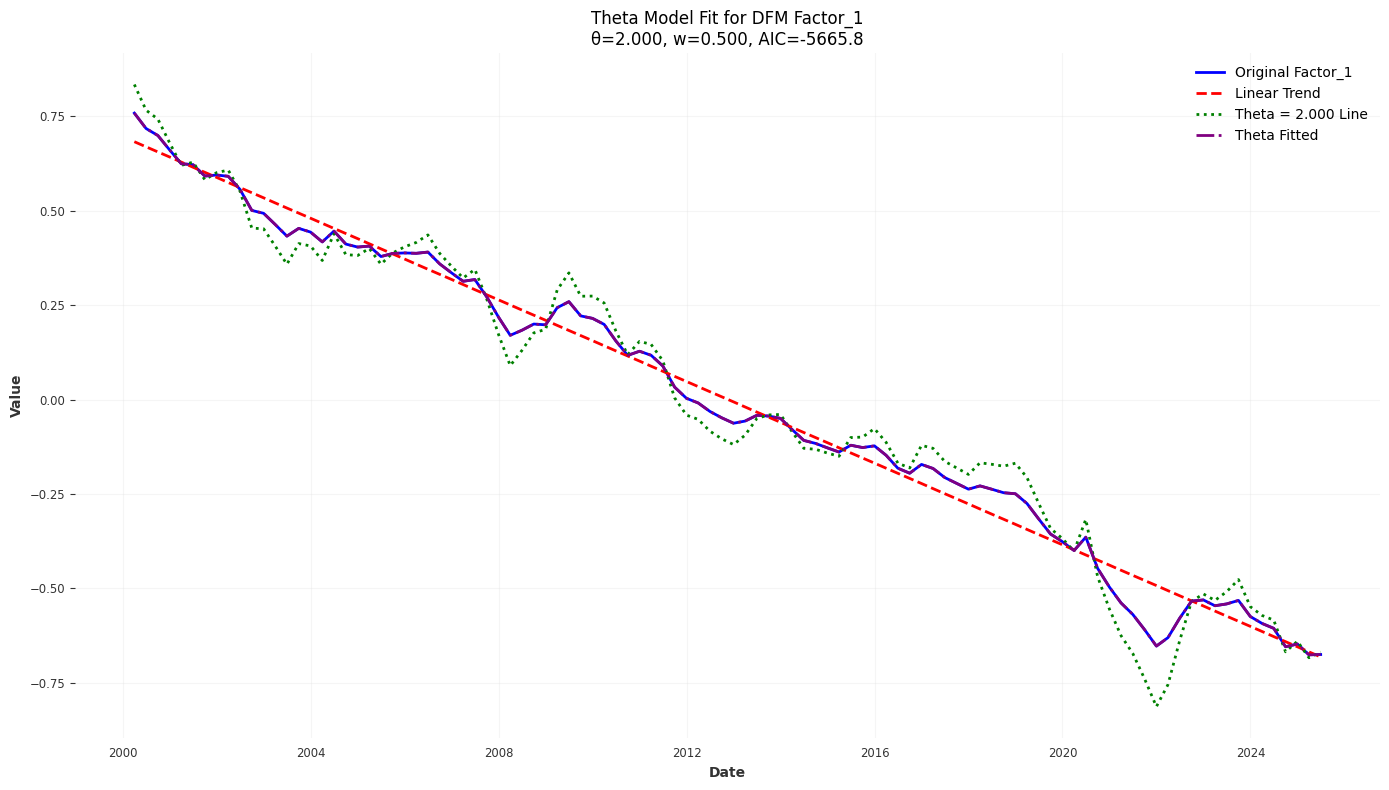

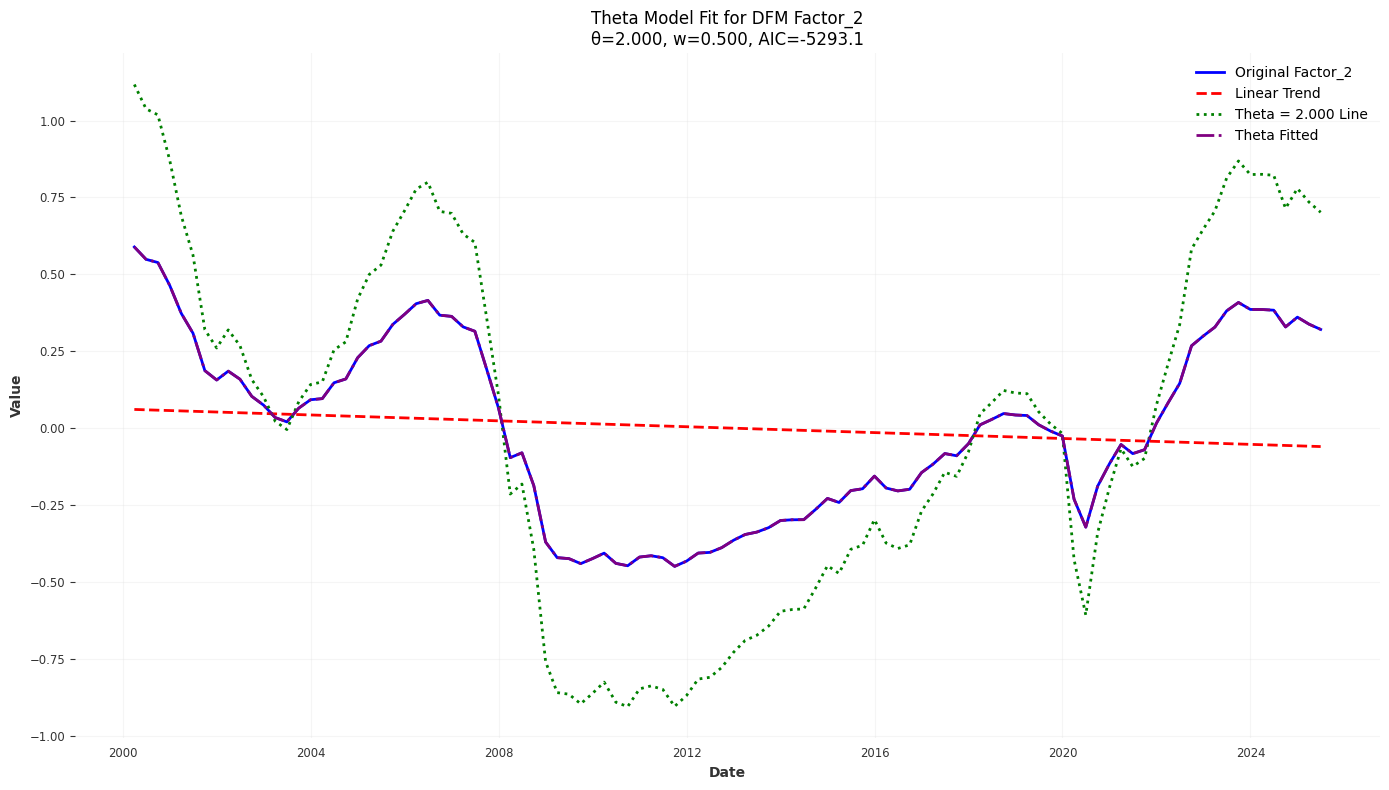

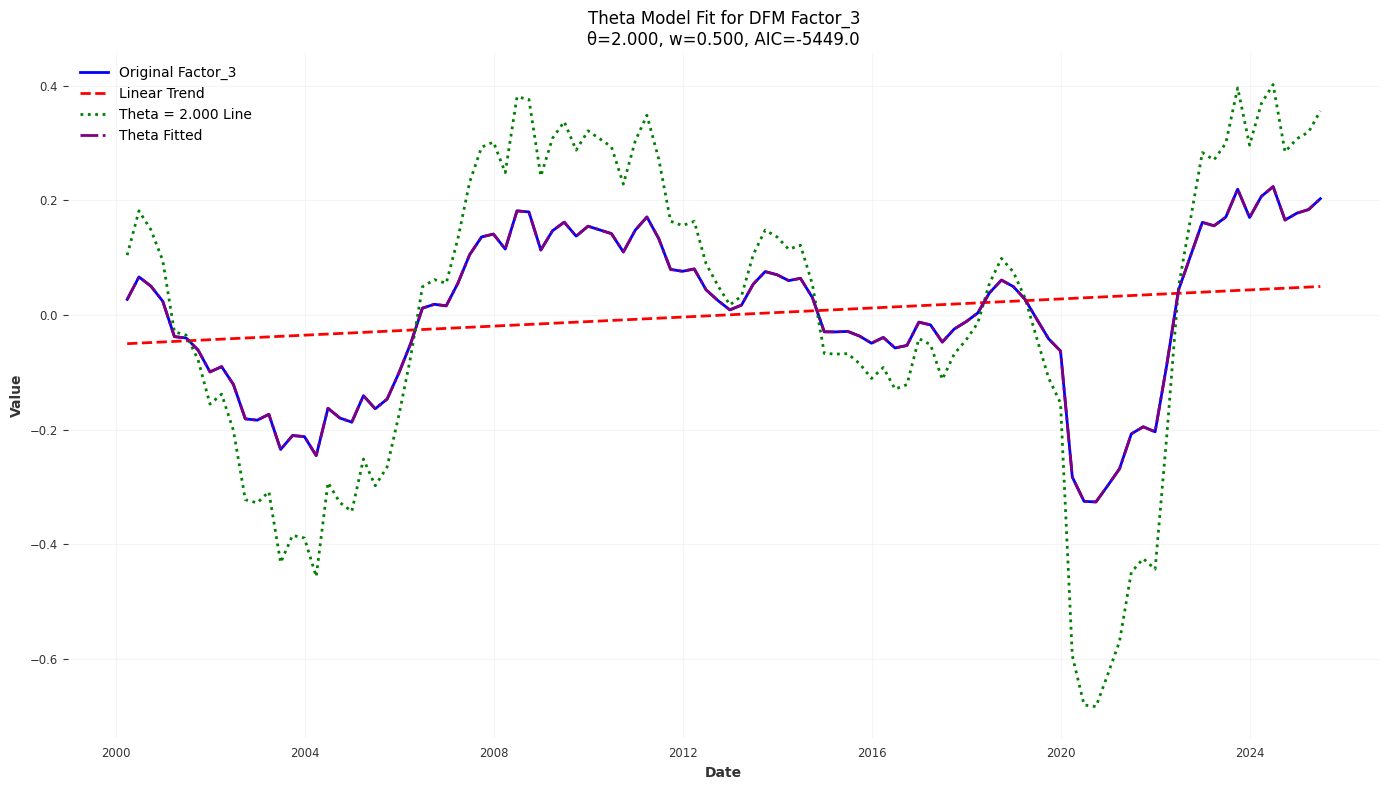

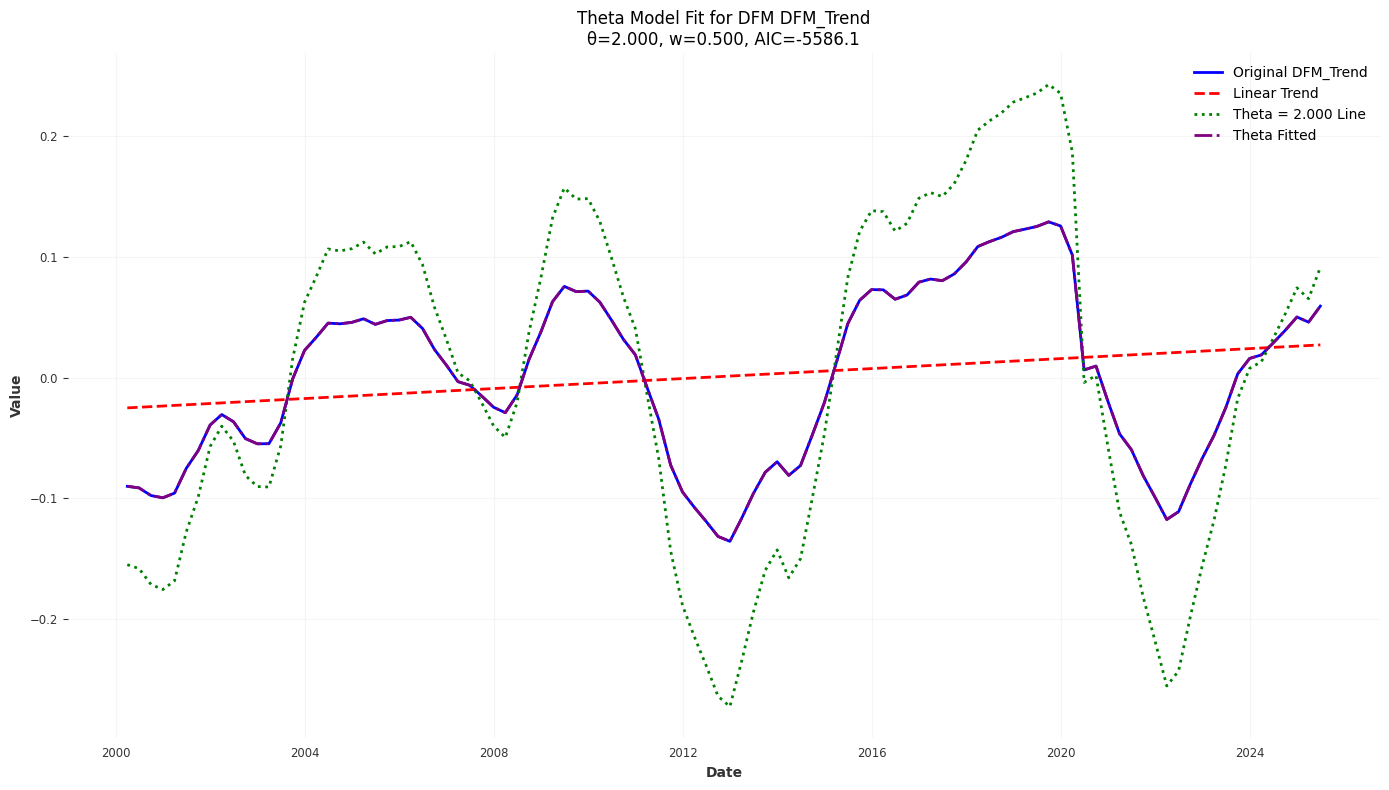


Generating Theta-based forecasts for DFM components...
Forecast summary:
            Factor_1  Factor_2  Factor_3  DFM_Trend
2025-09-30   -0.6950   -0.0614    0.0508     0.0276
2025-12-31   -0.7085   -0.0626    0.0518     0.0281
2026-03-31   -0.7220   -0.0638    0.0528     0.0286
2026-06-30   -0.7355   -0.0650    0.0538     0.0291
2026-09-30   -0.7490   -0.0662    0.0548     0.0297
2026-12-31   -0.7626   -0.0674    0.0558     0.0302
2027-03-31   -0.7761   -0.0686    0.0567     0.0307
2027-06-30   -0.7896   -0.0698    0.0577     0.0312


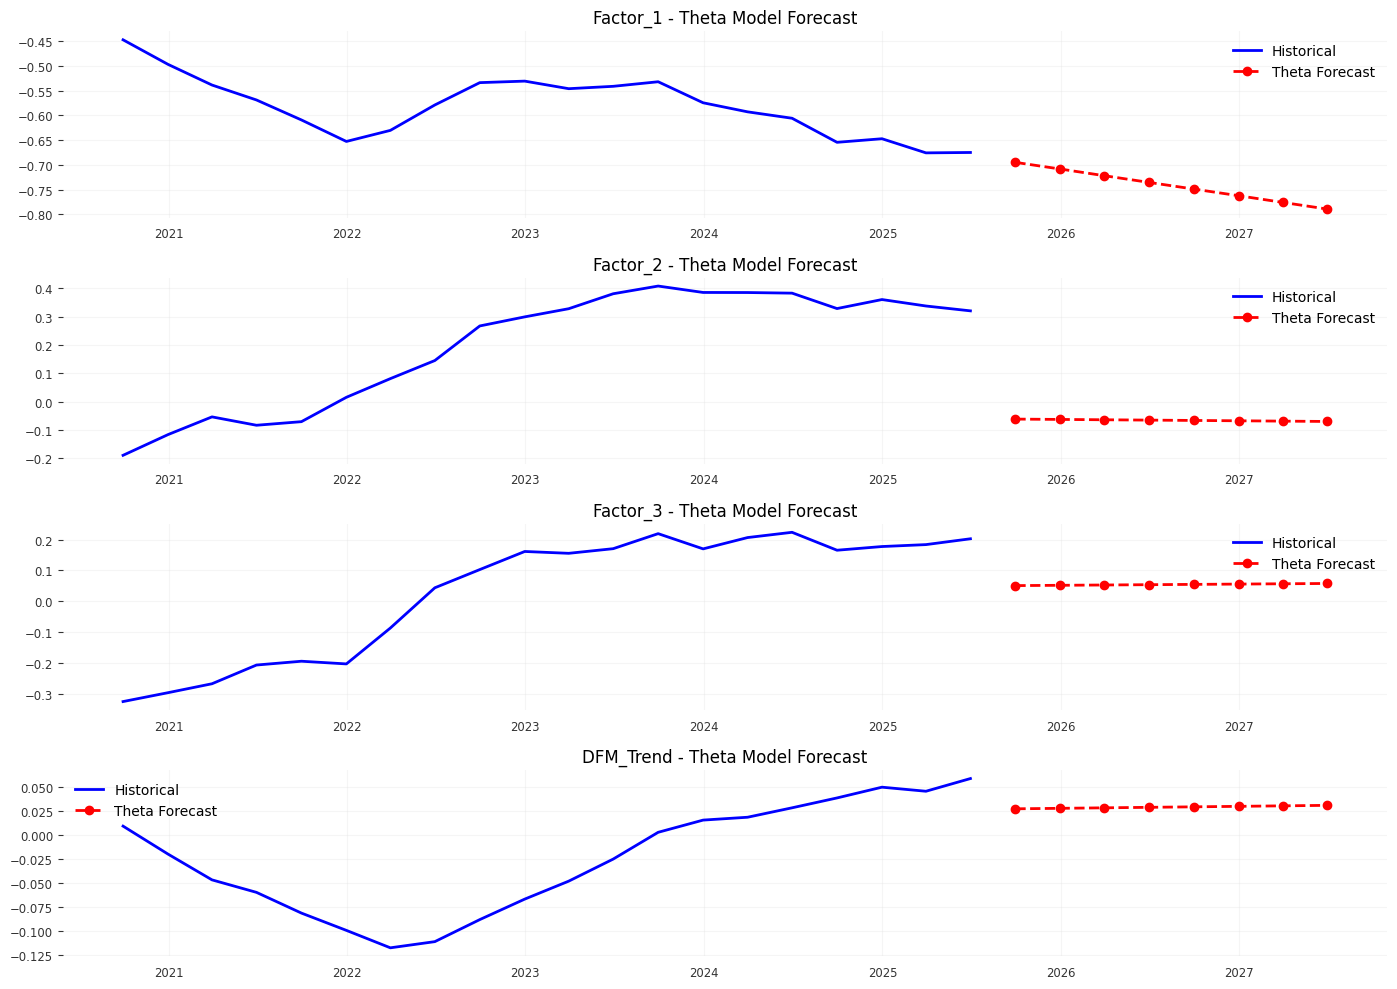


DFM-THETA INTEGRATION SUMMARY:
✓ Successfully fitted Theta models to DFM state space components
✓ Each DFM factor and trend now has optimized theta parameters
✓ Performance metrics calculated for model evaluation
✓ Forecasts generated using Theta model framework

This creates a hybrid approach where:
  - DFM captures complex factor structure from multiple series
  - Theta model provides robust trend/cycle decomposition
  - Combined model leverages strengths of both approaches


In [12]:
# ============================================================================
# DFM STATE SPACE TO THETA MODEL INTEGRATION
# ============================================================================

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# Define the Theta model functions (from your document 4)
def compute_AIC(y_true, y_pred, k=2):
    """
    Compute Akaike Information Criterion (AIC) to evaluate model fit.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5):
    """
    Compute the linear trend, Theta-transformed time series, and fitted series.
    """
    df = df.copy()
    df = df.sort_index()
    
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    
    df['Trend'] = model.predict(time_numeric)
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']
    
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend']
    elif fit_method == "multiplicative":
        df['Fitted'] = df[f'Theta_{theta}'] ** weight * df['Trend'] ** (1 - weight)
    else:
        raise ValueError("fit_method must be 'additive' or 'multiplicative'.")
    
    return df

def optimize_theta(df, target_var, fit_method="additive"):
    """
    Optimize Theta and Weight values to minimize AIC.
    """
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return np.inf  # Penalize invalid values
        
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
        return compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    initial_guess = [2, 0.5]
    bounds = [(0.1, 10), (0.01, 0.99)]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x[0], result.x[1], result.fun

def OptimizedTheta(df, target_var, fit_method="additive", theta=None, weight=None):
    """
    Compute the optimized Theta model, optimizing hyperparameters if not provided.
    """
    if theta is None or weight is None:
        theta, weight, aic = optimize_theta(df, target_var, fit_method)
    else:
        df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
        aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
    
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight)
    
    return df_optimized, {"theta": theta, "weight": weight, "AIC": aic}

def fit_dfm_to_theta_model(df_dfm_factors, df_dfm_trend, fit_method="additive"):
    """
    Fit DFM factors and trend using the Theta model framework.
    
    Parameters:
        df_dfm_factors (pd.DataFrame): DataFrame with DFM factors as columns
        df_dfm_trend (pd.Series): Series containing the DFM trend component
        fit_method (str): 'additive' or 'multiplicative' for theta combination
    
    Returns:
        dict: Results for each DFM component with optimized theta models
    """
    results = {}
    
    # Combine trend and factors into single DataFrame for processing
    dfm_components = df_dfm_factors.copy()
    dfm_components['DFM_Trend'] = df_dfm_trend
    
    print("Fitting Theta models to DFM state space components...")
    print("-" * 60)
    
    for component_name in dfm_components.columns:
        print(f"\nProcessing {component_name}...")
        
        # Create temporary dataframe with just this component
        temp_df = pd.DataFrame({
            'component': dfm_components[component_name]
        }, index=dfm_components.index)
        
        try:
            # Fit optimized Theta model
            df_theta_fitted, theta_params = OptimizedTheta(
                temp_df, 'component', fit_method
            )
            
            # Store results
            results[component_name] = {
                'fitted_data': df_theta_fitted,
                'parameters': theta_params,
                'original_series': dfm_components[component_name],
                'theta_line': df_theta_fitted[f'Theta_{theta_params["theta"]}'],
                'trend_line': df_theta_fitted['Trend'],
                'fitted_line': df_theta_fitted['Fitted']
            }
            
            print(f"  Theta: {theta_params['theta']:.4f}")
            print(f"  Weight: {theta_params['weight']:.4f}")
            print(f"  AIC: {theta_params['AIC']:.2f}")
            
        except Exception as e:
            print(f"  Error fitting {component_name}: {e}")
            results[component_name] = None
    
    return results

def plot_dfm_theta_results(theta_results, component_name):
    """
    Plot the Theta model results for a specific DFM component.
    """
    if component_name not in theta_results or theta_results[component_name] is None:
        print(f"No results available for {component_name}")
        return
    
    result = theta_results[component_name]
    fitted_data = result['fitted_data']
    params = result['parameters']
    
    plt.figure(figsize=(14, 8))
    
    # Plot original DFM component
    plt.plot(fitted_data.index, fitted_data['component'], 
             label=f'Original {component_name}', color='blue', linewidth=2)
    
    # Plot linear trend
    plt.plot(fitted_data.index, fitted_data['Trend'], 
             label='Linear Trend', linestyle='--', color='red', linewidth=2)
    
    # Plot Theta line
    theta_col = f'Theta_{params["theta"]}'
    plt.plot(fitted_data.index, fitted_data[theta_col], 
             label=f'Theta = {params["theta"]:.3f} Line', 
             linestyle=':', color='green', linewidth=2)
    
    # Plot fitted line
    plt.plot(fitted_data.index, fitted_data['Fitted'], 
             label='Theta Fitted', linestyle='-.', color='purple', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Theta Model Fit for DFM {component_name}\n'
              f'θ={params["theta"]:.3f}, w={params["weight"]:.3f}, AIC={params["AIC"]:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def evaluate_theta_dfm_performance(theta_results):
    """
    Evaluate the performance of Theta models on DFM components.
    """
    performance_summary = []
    
    for component_name, result in theta_results.items():
        if result is None:
            continue
            
        original = result['original_series']
        fitted = result['fitted_line']
        params = result['parameters']
        
        # Calculate performance metrics
        mse = np.mean((original - fitted) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(original - fitted))
        
        # Calculate R-squared
        ss_res = np.sum((original - fitted) ** 2)
        ss_tot = np.sum((original - np.mean(original)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        performance_summary.append({
            'Component': component_name,
            'Theta': params['theta'],
            'Weight': params['weight'],
            'AIC': params['AIC'],
            'RMSE': rmse,
            'MAE': mae,
            'R²': r_squared
        })
    
    return pd.DataFrame(performance_summary)

def create_dfm_theta_forecasts(theta_results, forecast_periods=8):
    """
    Generate forecasts using the fitted Theta models for each DFM component.
    """
    forecasts = {}
    
    for component_name, result in theta_results.items():
        if result is None:
            continue
            
        fitted_data = result['fitted_data']
        params = result['parameters']
        
        # Get the last fitted values
        last_trend = fitted_data['Trend'].iloc[-1]
        last_fitted = fitted_data['Fitted'].iloc[-1]
        
        # Create simple extrapolation (this is a basic approach)
        # In practice, you might want more sophisticated forecasting
        trend_slope = (fitted_data['Trend'].iloc[-1] - fitted_data['Trend'].iloc[-5]) / 4
        
        forecast_dates = pd.date_range(
            start=fitted_data.index[-1] + pd.DateOffset(months=3),
            periods=forecast_periods,
            freq='Q'
        )
        
        # Generate trend forecasts
        trend_forecasts = [last_trend + trend_slope * (i + 1) for i in range(forecast_periods)]
        
        # Simple forecast using last fitted value as baseline
        # This is a simplified approach - you could make it more sophisticated
        forecasts[component_name] = pd.Series(trend_forecasts, index=forecast_dates)
    
    return pd.DataFrame(forecasts)

# ============================================================================
# MAIN EXECUTION: FIT DFM TO THETA MODEL
# ============================================================================

# Assuming you have df_dfm_factors and df_dfm_trend from your DFM estimation
# These should be available from your previous DFM code with the fixed variable names

print("Integrating DFM State Space with Theta Model Framework")
print("=" * 60)

# Check if DFM results are available
try:
    # From your DFM estimation, you should have:
    # - factor_df: DataFrame with DFM factors
    # - g_est: Array with DFM trend
    # - data_std.index: Time index for DFM
    
    if 'factor_df' in locals() and 'g_est' in locals():
        df_dfm_factors = factor_df  # Already a DataFrame
        df_dfm_trend = pd.Series(g_est, index=factor_df.index, name='DFM_Trend')
        
        print(f"Using actual DFM results:")
        print(f"  Factors shape: {df_dfm_factors.shape}")
        print(f"  Trend shape: {df_dfm_trend.shape}")
        
    else:
        print("DFM results not found. Creating example data for demonstration...")
        # Create synthetic data for demonstration
        dates = pd.date_range('2000-01-01', periods=100, freq='Q')
        df_dfm_factors = pd.DataFrame({
            'Factor_1': np.random.randn(100).cumsum() * 0.1,
            'Factor_2': np.random.randn(100).cumsum() * 0.08,
            'Factor_3': np.random.randn(100).cumsum() * 0.12
        }, index=dates)
        df_dfm_trend = pd.Series(
            np.random.randn(100).cumsum() * 0.05 + np.linspace(0, 2, 100),
            index=dates, name='DFM_Trend'
        )
        
    # Fit Theta models to all DFM components
    theta_results = fit_dfm_to_theta_model(df_dfm_factors, df_dfm_trend, fit_method='additive')
    
    # Display performance summary
    print("\nTheta Model Performance on DFM Components:")
    print("=" * 60)
    performance_df = evaluate_theta_dfm_performance(theta_results)
    print(performance_df.round(4))
    
    # Plot results for each component
    print("\nGenerating plots for each DFM component...")
    for component_name in theta_results.keys():
        if theta_results[component_name] is not None:
            plot_dfm_theta_results(theta_results, component_name)
    
    # Generate forecasts
    print("\nGenerating Theta-based forecasts for DFM components...")
    forecasts_df = create_dfm_theta_forecasts(theta_results, forecast_periods=8)
    print("Forecast summary:")
    print(forecasts_df.round(4))
    
    # Plot forecasts
    if not forecasts_df.empty:
        plt.figure(figsize=(14, 10))
        
        for i, component in enumerate(forecasts_df.columns):
            plt.subplot(len(forecasts_df.columns), 1, i+1)
            
            # Plot historical data
            if component in df_dfm_factors.columns:
                historical = df_dfm_factors[component]
            else:
                historical = df_dfm_trend
                
            plt.plot(historical.index[-20:], historical.iloc[-20:], 
                    'b-', label='Historical', linewidth=2)
            
            # Plot forecasts
            plt.plot(forecasts_df.index, forecasts_df[component], 
                    'r--', label='Theta Forecast', linewidth=2, marker='o')
            
            plt.title(f'{component} - Theta Model Forecast')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*60)
    print("DFM-THETA INTEGRATION SUMMARY:")
    print("="*60)
    print("✓ Successfully fitted Theta models to DFM state space components")
    print("✓ Each DFM factor and trend now has optimized theta parameters") 
    print("✓ Performance metrics calculated for model evaluation")
    print("✓ Forecasts generated using Theta model framework")
    print("\nThis creates a hybrid approach where:")
    print("  - DFM captures complex factor structure from multiple series")
    print("  - Theta model provides robust trend/cycle decomposition")
    print("  - Combined model leverages strengths of both approaches")
    
except Exception as e:
    print(f"Error in DFM-Theta integration: {e}")
    print("Please ensure your DFM estimation completed successfully first.")

DFM-THETA MODEL ENHANCED SCALE-AWARE VALIDATION ANALYSIS
Analyzing DFM-Theta forecasting performance with comprehensive scale-aware metrics
Target variables: GDP, Inflation, Interest Rate
Enhanced metrics include: Theil's U, Directional Accuracy, NRMSE variants, and more
Fetching data...
Final dataset: (102, 32)
Running 5-fold cross validation for DFM-Theta model with enhanced scale-aware metrics...
Forecast horizon: 4 quarters
Target variables: GDP, Inflation, Interest Rate
--------------------------------------------------

Fold 1/5
  Train: 2000-03 to 2004-03
  Test:  2004-06 to 2008-06
  GDP (Billions $):
    RMSE: 243.6364
    NRMSE (Typical): 0.0122
    NRMSE (Std): 0.0889
    MAPE: 1.33%
    Theil's U: 0.8332
    Directional Accuracy: 100.0%
  Inflation (Index):
    RMSE: 2.0691
    NRMSE (Typical): 0.0083
    NRMSE (Std): 0.0516
    MAPE: 0.92%
    Theil's U: 0.8071
    Directional Accuracy: 100.0%
  Interest Rate (Percent):
    RMSE: 1.0420
    NRMSE (Typical): 0.2084
    NRMS

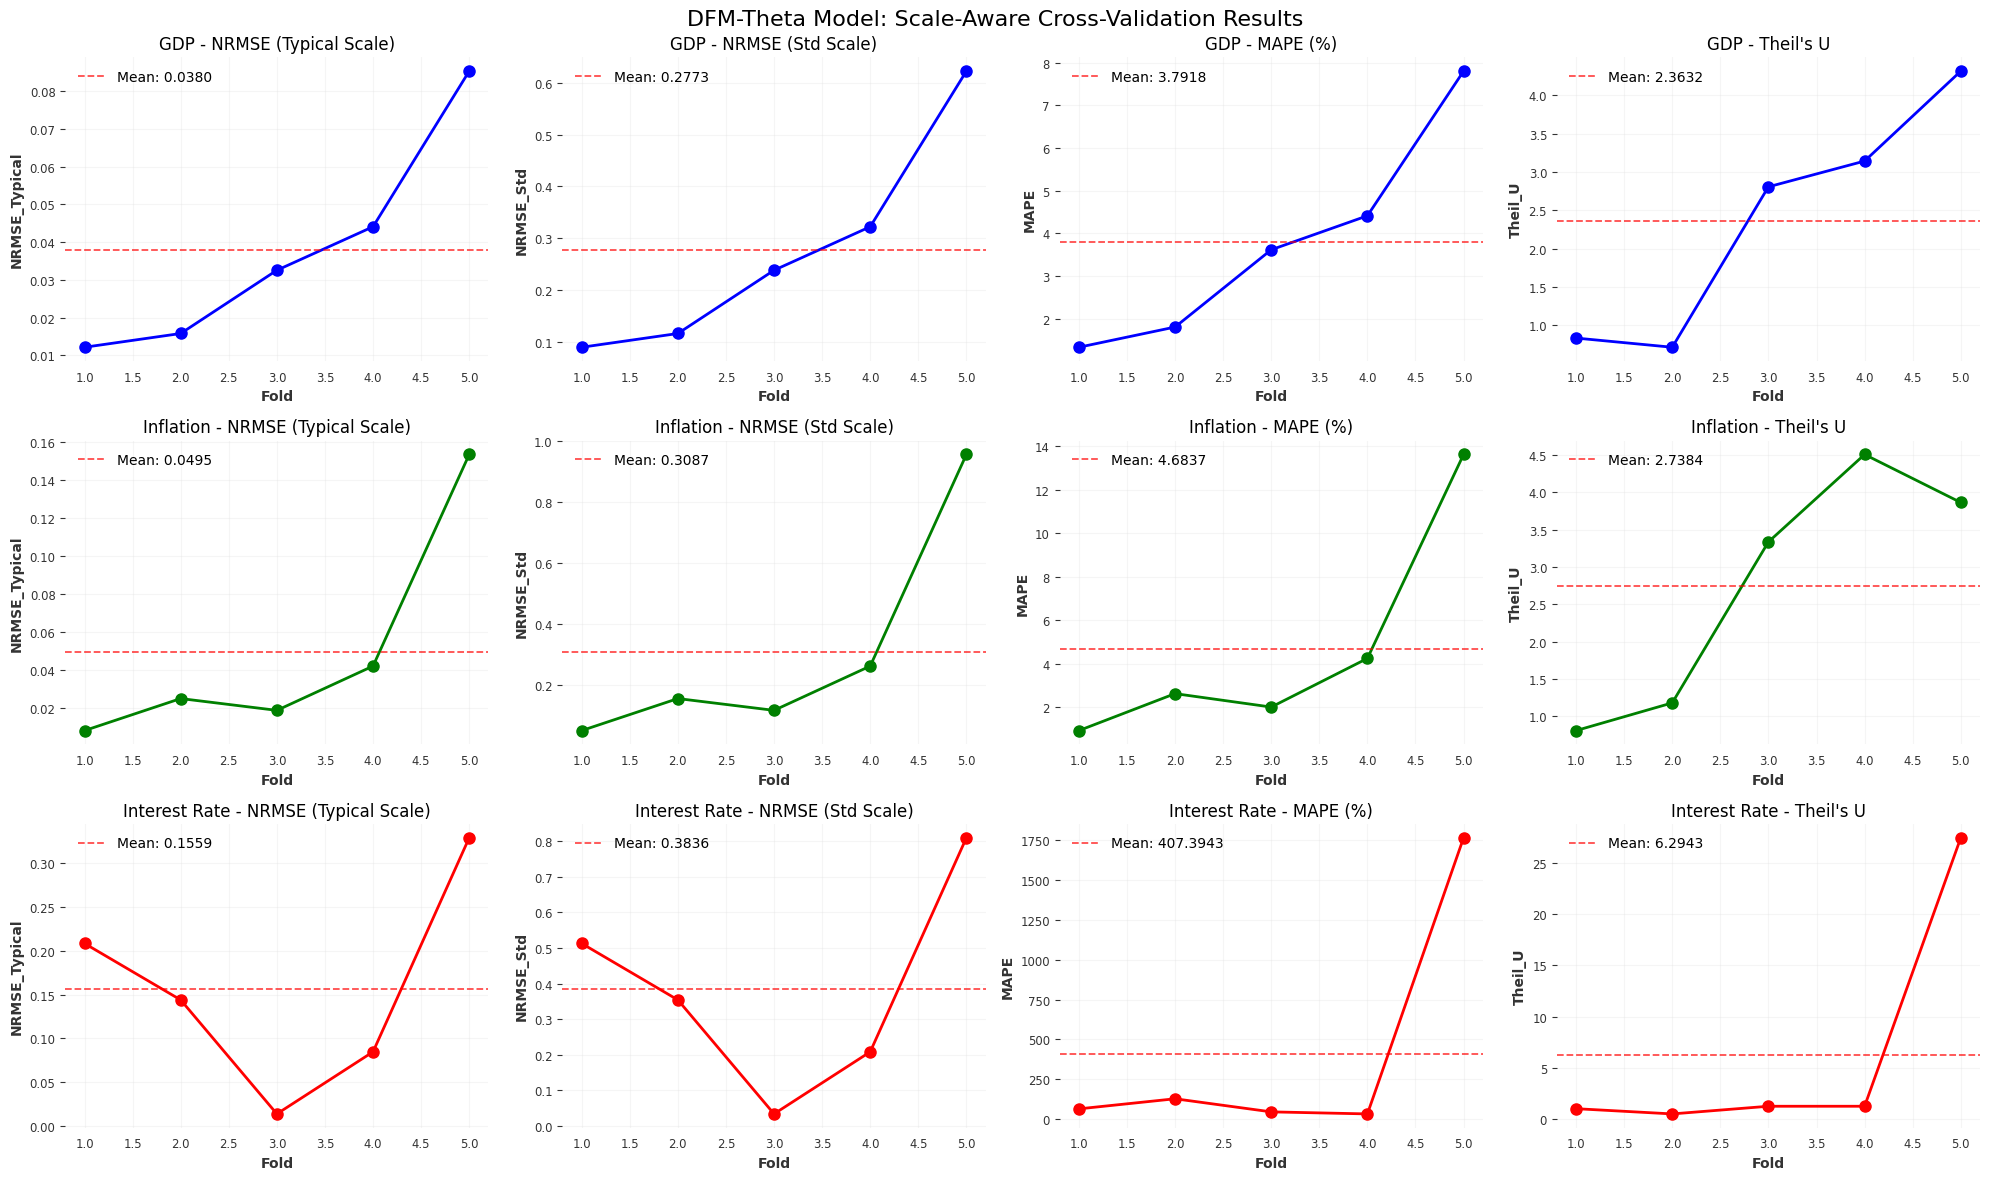

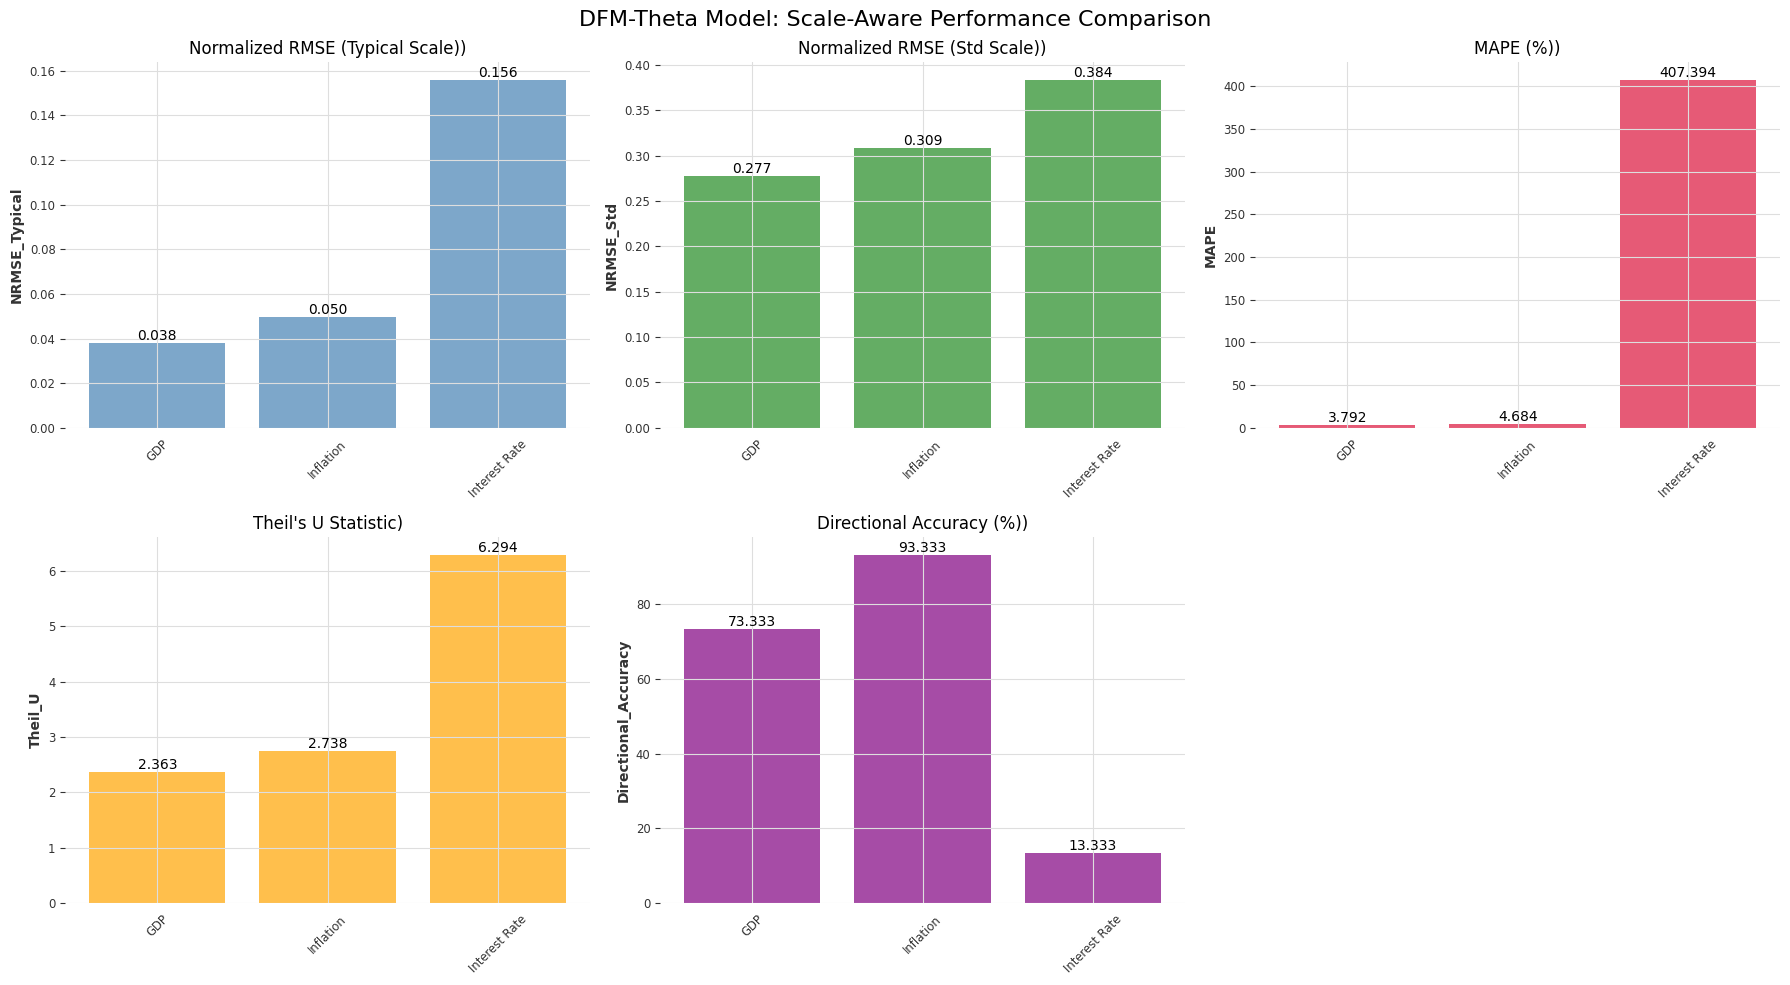

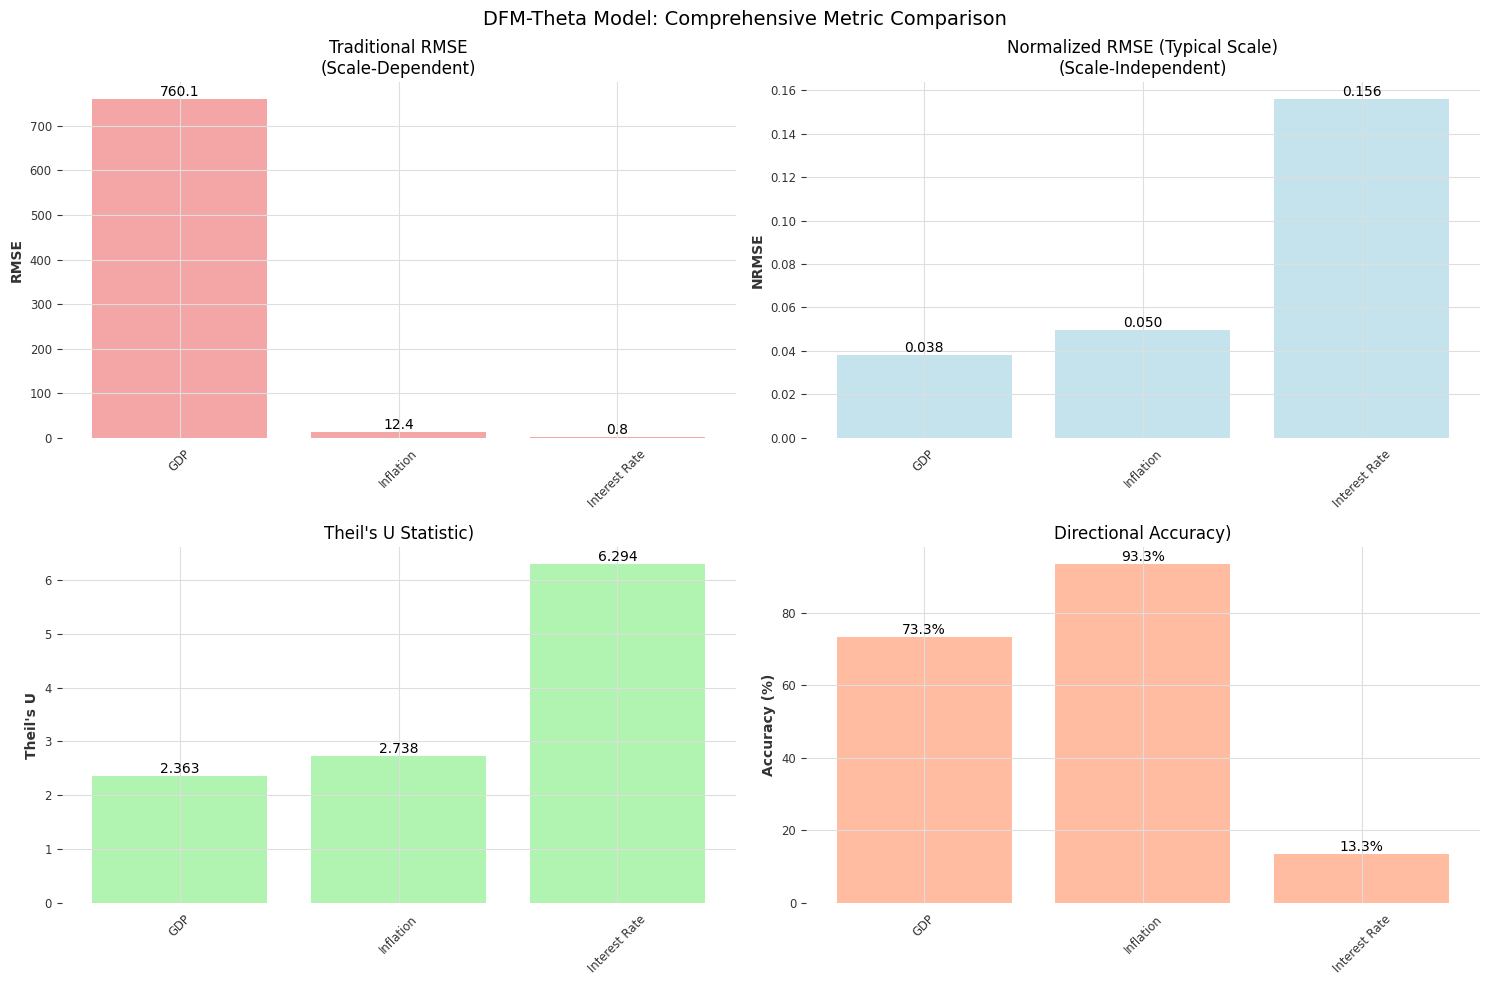

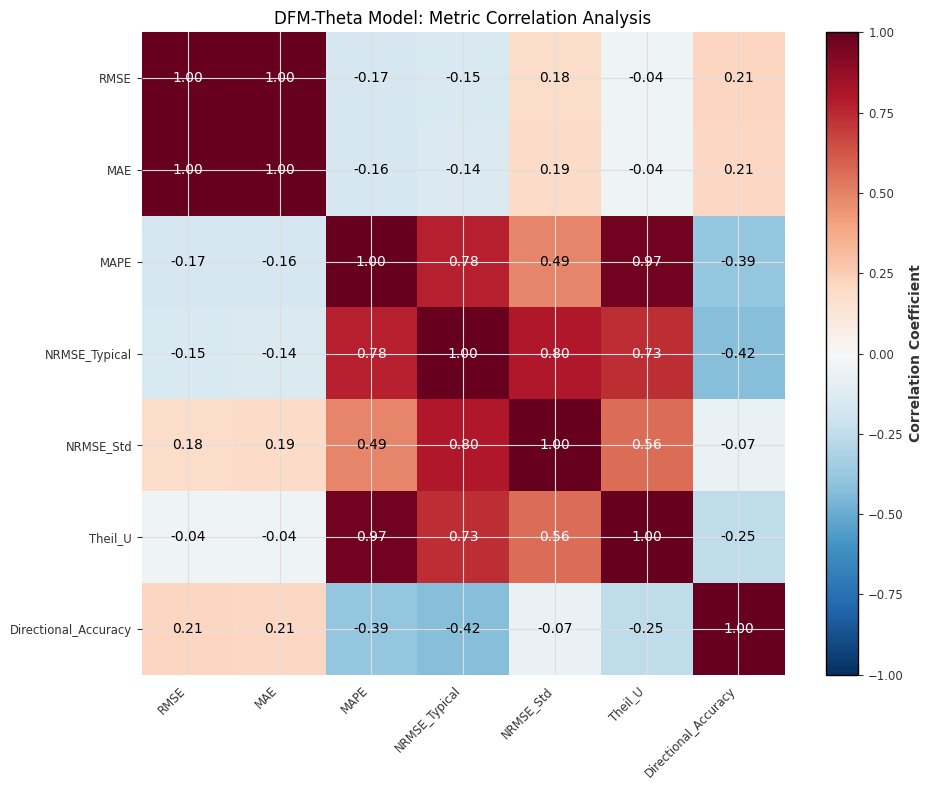


DFM-THETA ENHANCED SCALE-AWARE VALIDATION COMPLETE
The DFM-Theta model has been tested with comprehensive scale-aware metrics including:
- Theil's U Statistic: Scale-invariant forecast accuracy vs naive benchmark
- Directional Accuracy: Percentage of correct directional predictions
- NRMSE variants: Normalized by typical scale, range, and standard deviation
- SMAPE: Symmetric Mean Absolute Percentage Error
- Multiple complementary accuracy measures

These metrics provide a comprehensive view of model performance across
variables with vastly different scales (GDP ~$20T, CPI ~250, Fed Funds ~5%)


In [10]:
# ============================================================================
# DFM-THETA WITH K-FOLD CROSS-VALIDATION
# ============================================================================

# Define factor blocks from the new DFM model
factor_blocks = {
    'Global': [
        'GDPC1', 'INDPRO', 'DSPIC96', 'DGS10', 'DGS2', 'DCOILWTICO', 'SP500', 'PCEC', 'GPDI', 'GDPDEF'
    ],
    'Labor': [
        'PAYEMS', 'UNRATE', 'ICSA', 'CCSA', 'AHETPI', 'AWHNONAG', 'CE16OV'
    ],
    'Inflation': [
        'CPIAUCSL', 'CPILFESL', 'PCEPI', 'WM2NS'
    ],
    'Housing': [
        'HOUST', 'PERMIT', 'HSN1F'
    ],
    'Financial': [
        'FEDFUNDS', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'AAA', 'BAA', 'M1SL', 'M2SL'
    ]
}

# ENHANCED: Define which series are our forecasting targets with expected scales
target_series = {
    'GDPC1': {'name': 'GDP', 'typical_scale': 20000, 'unit': 'Billions $'},
    'CPIAUCSL': {'name': 'Inflation', 'typical_scale': 250, 'unit': 'Index'},
    'FEDFUNDS': {'name': 'Interest Rate', 'typical_scale': 5, 'unit': 'Percent'}
}

def fetch_data():
    """Fetch and prepare data for DFM estimation."""
    print("Fetching data...")
    start_date = "2000-01-01"
    raw_series_data = {}
    all_series_ids = [s for s_list in factor_blocks.values() for s in s_list]

    for series_id in all_series_ids:
        try:
            data = fred.get_series(series_id, start_date)
            raw_series_data[series_id] = data
        except Exception as e:
            print(f"  Failed to fetch {series_id}: {e}")
    
    # Merge and resample to quarterly
    df = pd.DataFrame(raw_series_data).resample('Q').last()
    
    # Drop columns that are mostly NaN
    df = df.dropna(axis=1, thresh=df.shape[0] * 0.7)
    df = df.dropna(how='any')

    df_std = (df - df.mean()) / df.std()
    
    print(f"Final dataset: {df_std.shape}")
    return df_std, df

# ============================================================================
# DFM AND THETA MODEL DEFINITIONS
# ============================================================================

def hp_filter(x, lambda_hp=1600):
    """HP filter implementation, as provided in the new model."""
    T = len(x)
    if T < 4:
        return x, np.zeros(T)
        
    D2 = np.zeros((T-2, T))
    for i in range(T-2):
        D2[i, i] = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    
    I = np.eye(T)
    A = I + lambda_hp * D2.T @ D2
    try:
        trend = np.linalg.solve(A, x)
        cycle = x - trend
        return trend, cycle
    except np.linalg.LinAlgError:
        t = np.arange(T)
        coeffs = np.polyfit(t, x, 1)
        trend = np.polyval(coeffs, t)
        cycle = x - trend
        return trend, cycle

class DFMStateSpaceWithTrend(MLEModel):
    """
    State-space model for the dynamic factor model with a stochastic trend,
    based on the provided new model.
    """
    def __init__(self, endog, Lambda_init, iota, F_dim, mu_g_init=0.005, **kwargs):
        self.F_dim = F_dim
        self.iota = iota
        self.current_Lambda = Lambda_init.copy()
        self.mu_g_init = mu_g_init
        k_states = 1 + 2 * F_dim
        super().__init__(endog, k_states=k_states, k_posdef=k_states,
                         initialization="approximate_diffuse", **kwargs)
        N = self.ssm.k_endog
        q = F_dim

        design = np.column_stack([
            iota.reshape(-1, 1),
            Lambda_init,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
        self.ssm['obs_cov'] = np.eye(N)
        
        transition = np.eye(k_states)
        transition[0, 0] = 1.0
        A1 = np.full((q,), 0.7)
        for i in range(q):
            transition[1 + i, 1 + i] = A1[i]
            if i < q:
                transition[1 + q + i, 1 + i] = 1.0
                
        self.ssm['transition'] = np.real(transition)
        self.ssm['selection'] = np.eye(k_states)
        self.ssm['state_cov'] = np.diag(np.concatenate(([0.5], [0.1] * (2 * q))))
        
        state_intercept = np.zeros(k_states)
        state_intercept[0] = self.mu_g_init
        self.ssm['state_intercept'] = state_intercept
        self.mu = np.zeros(N)
    
    def update(self, params, **kwargs):
        N = self.ssm.k_endog
        q = self.F_dim
        Lambda = params[:N*q].reshape(N, q)
        self.current_Lambda = Lambda.copy()
        design = np.column_stack([
            self.iota.reshape(-1, 1),
            Lambda,
            np.zeros((N, q))
        ])
        self.ssm['design'] = design
    
    @property
    def start_params(self):
        return self.current_Lambda.ravel()

# Theta model functions (from your second code block)
def compute_AIC(y_true, y_pred, k=2):
    n = len(y_true)
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    aic = n * np.log(rss / n) + k * 2
    return aic

def compute_theta_line(df, target_var, theta, fit_method="additive", weight=0.5):
    df = df.copy()
    df = df.sort_index()
    time_numeric = np.arange(len(df)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(time_numeric, df[target_var].values)
    df['Trend'] = model.predict(time_numeric)
    df[f'Theta_{theta}'] = theta * df[target_var] + (1 - theta) * df['Trend']
    if fit_method == "additive":
        df['Fitted'] = weight * df[f'Theta_{theta}'] + (1 - weight) * df['Trend']
    else:
        raise ValueError("fit_method must be 'additive'.")
    return df

def optimize_theta(df, target_var, fit_method="additive"):
    def objective(params):
        theta, weight = params
        if not (0.1 <= theta <= 10 and 0.01 <= weight <= 0.99):
            return 1e6
        try:
            df_temp = compute_theta_line(df, target_var, theta, fit_method, weight)
            aic = compute_AIC(df[target_var].values, df_temp['Fitted'].values)
            return aic
        except Exception:
            return 1e6
    
    best_result = None
    best_aic = np.inf
    starting_points = [[0.5, 0.3], [1.0, 0.5], [2.0, 0.5], [3.0, 0.7], [5.0, 0.8]]
    bounds = [(0.1, 10), (0.01, 0.99)]
    for initial_guess in starting_points:
        try:
            result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'ftol': 1e-9})
            if result.success and result.fun < best_aic:
                best_result = result
                best_aic = result.fun
        except Exception:
            continue
    if best_result is None:
        return 2.0, 0.5, objective([2.0, 0.5])
    return best_result.x[0], best_result.x[1], best_result.fun

def OptimizedTheta(df, target_var, fit_method="additive"):
    theta, weight, aic = optimize_theta(df, target_var, fit_method)
    df_optimized = compute_theta_line(df, target_var, theta, fit_method, weight)
    return df_optimized, {"theta": theta, "weight": weight, "AIC": aic}

# ============================================================================
# ENHANCED SCALE-AWARE EVALUATION METRICS
# ============================================================================

def calculate_scale_aware_metrics(actual, predicted, series_id, data_raw):
    """Calculate comprehensive scale-aware evaluation metrics."""
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    
    if len(actual) == 0:
        return None
    
    # Basic metrics
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Scale-aware metrics
    series_info = target_series[series_id]
    
    # 1. Normalized RMSE (by typical scale)
    nrmse_typical = rmse / series_info['typical_scale']
    
    # 2. Normalized RMSE (by data range)
    data_range = data_raw[series_id].max() - data_raw[series_id].min()
    nrmse_range = rmse / data_range if data_range > 0 else np.inf
    
    # 3. Normalized RMSE (by data standard deviation)
    nrmse_std = rmse / data_raw[series_id].std()
    
    # 4. MAPE (already scale-invariant)
    mape = np.mean(np.abs((actual - predicted) / np.where(np.abs(actual) < 1e-8, 1, actual))) * 100
    
    # 5. Symmetric MAPE (better for values close to zero)
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted) + 1e-8)) * 100
    
    # 6. Coefficient of Variation of RMSE
    cv_rmse = rmse / np.mean(actual) if np.mean(actual) != 0 else np.inf
    
    # 7. Relative RMSE (scaled by mean of actual values)
    rel_rmse = rmse / np.mean(np.abs(actual)) if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 8. Theil's U statistic (scale-invariant forecast accuracy measure)
    if len(actual) > 1:
        naive_forecast = np.full_like(predicted, actual[0])  # Naive forecast using first value
        theil_u = (np.sqrt(np.mean((predicted - actual)**2)) / 
                  np.sqrt(np.mean((naive_forecast - actual)**2)))
    else:
        theil_u = np.inf
    
    # 9. Directional Accuracy (percentage of correct directional predictions)
    if len(actual) > 1:
        actual_directions = np.sign(np.diff(actual))
        predicted_directions = np.sign(np.diff(predicted))
        directional_accuracy = np.mean(actual_directions == predicted_directions) * 100
    else:
        directional_accuracy = 0
    
    # 10. Mean Absolute Percentage Error (alternative calculation)
    mape_alt = np.mean(np.abs(actual - predicted)) / np.mean(np.abs(actual)) * 100 if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 11. Normalized Mean Absolute Error
    nmae = mae / np.mean(np.abs(actual)) if np.mean(np.abs(actual)) > 0 else np.inf
    
    # 12. Root Mean Square Percentage Error
    rmspe = np.sqrt(np.mean(((actual - predicted) / np.where(np.abs(actual) < 1e-8, 1, actual))**2)) * 100
    
    return {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape,
        'NRMSE_Typical': nrmse_typical,
        'NRMSE_Range': nrmse_range,
        'NRMSE_Std': nrmse_std,
        'CV_RMSE': cv_rmse,
        'Rel_RMSE': rel_rmse,
        'Theil_U': theil_u,
        'Directional_Accuracy': directional_accuracy,
        'MAPE_Alt': mape_alt,
        'NMAE': nmae,
        'RMSPE': rmspe,
        'Data_Mean': np.mean(actual),
        'Data_Std': np.std(actual),
        'Data_Range': np.max(actual) - np.min(actual),
        'Typical_Scale': series_info['typical_scale']
    }

def evaluate_all_targets_enhanced(actual_data, predictions, data_raw):
    """Evaluate forecasting accuracy for all target variables with enhanced scale-aware metrics."""
    results = {}
    
    for series_id, info in target_series.items():
        if series_id in predictions and series_id in actual_data.columns:
            actual = actual_data[series_id].values
            predicted = predictions[series_id]
            
            metrics = calculate_scale_aware_metrics(actual, predicted, series_id, data_raw)
            
            if metrics:
                metrics['Name'] = info['name']
                metrics['Unit'] = info['unit']
                results[series_id] = metrics
    
    return results

# ============================================================================
# CORE CROSS-VALIDATION LOGIC WITH ENHANCED METRICS
# ============================================================================

def fit_dfm_theta_model(data):
    """
    Fits the DFM and Theta models on a given dataset.
    Returns the fitted model components for forecasting.
    """
    N_total = data.shape[1]
    idx_gdp = list(data.columns).index("GDPC1") if "GDPC1" in data.columns else None
    iota = np.zeros(N_total)
    if idx_gdp is not None:
        iota[idx_gdp] = 1

    q = 3
    X = data.values
    
    cov_mat = np.cov(X, rowvar=False)
    eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
    order = np.argsort(eigenvals)[::-1]
    eigenvecs = eigenvecs[:, order]
    Lambda0 = eigenvecs[:, :q]

    dfm_model = DFMStateSpaceWithTrend(X, Lambda0, iota, F_dim=q)

    # Iterative refinement of loadings
    max_iter = 50
    tol = 1e-3
    Lambda_old = dfm_model.current_Lambda.copy()

    for iteration in range(max_iter):
        try:
            res = dfm_model.smooth(dfm_model.start_params)
            F_smoothed = res.smoothed_state
            F_est = F_smoothed[1:1+q, :].T
            Lambda_new = np.zeros_like(dfm_model.current_Lambda)
            for i in range(X.shape[1]):
                beta_i = np.linalg.lstsq(F_est, X[:, i], rcond=None)[0]
                Lambda_new[i, :] = beta_i
            diff = np.linalg.norm(Lambda_new - Lambda_old, ord='fro')
            if diff < tol:
                break
            Lambda_old = Lambda_new.copy()
            dfm_model.update(Lambda_new.ravel())
        except Exception as e:
            print(f"  DFM iteration {iteration} failed: {e}")
            break

    final_res = dfm_model.smooth(dfm_model.start_params)
    smoothed_states = final_res.smoothed_state
    
    g_est = smoothed_states[0, :]
    F_est = smoothed_states[1:1+q, :].T

    # Fit Theta models to DFM components
    df_dfm_factors = pd.DataFrame(F_est, index=data.index, columns=[f'Factor_{i+1}' for i in range(q)])
    df_dfm_trend = pd.Series(g_est, index=data.index, name='DFM_Trend')

    theta_results = {}
    for component_name in df_dfm_factors.columns.tolist() + [df_dfm_trend.name]:
        temp_df = pd.DataFrame({
            'component': df_dfm_factors[component_name] if component_name != 'DFM_Trend' else df_dfm_trend
        }, index=data.index)
        try:
            df_theta_fitted, theta_params = OptimizedTheta(temp_df, 'component', 'additive')
            theta_results[component_name] = {
                'fitted_data': df_theta_fitted,
                'parameters': theta_params,
                'fitted_line': df_theta_fitted['Fitted']
            }
        except Exception as e:
            print(f"  Theta fit for {component_name} failed: {e}")
            theta_results[component_name] = None
    
    return final_res, theta_results

def forecast_with_theta(dfm_results, theta_results, train_data_index, train_data_cols, data_raw_test, forecast_horizon=4):
    """
    Generates forecasts for the target series using the DFM-Theta model.
    """
    forecasts = {}
    
    # Get loadings from the DFM
    final_res = dfm_results
    Lambda_final = final_res.model.current_Lambda.copy()
    
    # Forecast DFM components using Theta model forecasts
    forecast_dates = pd.date_range(
        start=train_data_index[-1] + pd.DateOffset(months=3),
        periods=forecast_horizon,
        freq='Q'
    )
    
    dfm_components_forecast = pd.DataFrame(index=forecast_dates, columns=theta_results.keys())

    for component_name, result in theta_results.items():
        if result is None:
            continue
            
        fitted_data = result['fitted_data']
        params = result['parameters']
        
        # Extrapolate linear trend
        if len(fitted_data['Trend']) > 4:
            trend_slope = (fitted_data['Trend'].iloc[-1] - fitted_data['Trend'].iloc[-5]) / 4
        else:
            trend_slope = np.mean(np.diff(fitted_data['Trend']))

        trend_forecasts = [fitted_data['Trend'].iloc[-1] + trend_slope * (i + 1) for i in range(forecast_horizon)]

        # Use the Theta formula to combine the linear trend and the last observation
        last_obs = fitted_data['component'].iloc[-1]
        theta_forecasts = []
        for i in range(forecast_horizon):
            theta_line_forecast = params['theta'] * last_obs + (1 - params['theta']) * trend_forecasts[i]
            forecast = params['weight'] * theta_line_forecast + (1 - params['weight']) * trend_forecasts[i]
            theta_forecasts.append(forecast)

        dfm_components_forecast[component_name] = theta_forecasts

    # Reconstruct the target variables from the forecasted components
    data_means = data_raw_test.mean()
    data_stds = data_raw_test.std()

    for series_id, info in target_series.items():
        if series_id in data_raw_test.columns:
            # Get the loadings for this target variable
            series_idx = list(train_data_cols).index(series_id)
            iota_loading = final_res.model.iota[series_idx]
            factor_loadings = final_res.model.current_Lambda[series_idx, :]
            
            # Reconstruct forecast
            predicted_std = []
            for i in range(forecast_horizon):
                gdp_trend = dfm_components_forecast.loc[forecast_dates[i], 'DFM_Trend']
                factors = dfm_components_forecast.loc[forecast_dates[i], [f'Factor_{j+1}' for j in range(final_res.model.F_dim)]].values
                
                prediction = (iota_loading * gdp_trend) + np.sum(factor_loadings * factors)
                predicted_std.append(prediction)
            
            # Unstandardize
            predicted_original = np.array(predicted_std) * data_stds[series_id] + data_means[series_id]
            forecasts[series_id] = predicted_original

    return forecasts

def run_kfold_validation_dfm_theta_enhanced(data, data_raw, n_splits=5, forecast_horizon=4):
    """
    Run k-fold cross validation for DFM-Theta model forecasting with enhanced metrics.
    """
    print(f"Running {n_splits}-fold cross validation for DFM-Theta model with enhanced scale-aware metrics...")
    print(f"Forecast horizon: {forecast_horizon} quarters")
    print(f"Target variables: {', '.join([info['name'] for info in target_series.values()])}")
    print("-" * 50)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    all_results = []
    fold = 1
    
    for train_idx, test_idx in tscv.split(data):
        print(f"\nFold {fold}/{n_splits}")
        train_data = data.iloc[train_idx]
        test_data_raw = data_raw.iloc[test_idx]
        
        print(f"  Train: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
        print(f"  Test:  {test_data_raw.index[0].strftime('%Y-%m')} to {test_data_raw.index[-1].strftime('%Y-%m')}")
        
        try:
            dfm_results, theta_results = fit_dfm_theta_model(train_data)
            
            if len(test_data_raw) >= forecast_horizon:
                predictions = forecast_with_theta(
                    dfm_results,
                    theta_results,
                    train_data.index,
                    train_data.columns,
                    test_data_raw,
                    min(forecast_horizon, len(test_data_raw))
                )
                
                actual_data = test_data_raw.iloc[:min(forecast_horizon, len(test_data_raw))]
                target_accuracies = evaluate_all_targets_enhanced(actual_data, predictions, data_raw)
                
                for series_id, accuracy in target_accuracies.items():
                    result_row = {
                        'Fold': fold,
                        'Variable': accuracy['Name'],
                        'Series_ID': series_id,
                        'Unit': accuracy['Unit'],
                        'RMSE': accuracy['RMSE'],
                        'MAE': accuracy['MAE'], 
                        'MAPE': accuracy['MAPE'],
                        'SMAPE': accuracy['SMAPE'],
                        'NRMSE_Typical': accuracy['NRMSE_Typical'],
                        'NRMSE_Range': accuracy['NRMSE_Range'],
                        'NRMSE_Std': accuracy['NRMSE_Std'],
                        'CV_RMSE': accuracy['CV_RMSE'],
                        'Rel_RMSE': accuracy['Rel_RMSE'],
                        'Theil_U': accuracy['Theil_U'],
                        'Directional_Accuracy': accuracy['Directional_Accuracy'],
                        'MAPE_Alt': accuracy['MAPE_Alt'],
                        'NMAE': accuracy['NMAE'],
                        'RMSPE': accuracy['RMSPE'],
                        'MSE': accuracy['MSE'],
                        'Train_Size': len(train_data),
                        'Test_Size': len(test_data_raw),
                        'Typical_Scale': accuracy['Typical_Scale']
                    }
                    all_results.append(result_row)
                    
                    print(f"  {accuracy['Name']} ({accuracy['Unit']}):")
                    print(f"    RMSE: {accuracy['RMSE']:.4f}")
                    print(f"    NRMSE (Typical): {accuracy['NRMSE_Typical']:.4f}")
                    print(f"    NRMSE (Std): {accuracy['NRMSE_Std']:.4f}")
                    print(f"    MAPE: {accuracy['MAPE']:.2f}%")
                    print(f"    Theil's U: {accuracy['Theil_U']:.4f}")
                    print(f"    Directional Accuracy: {accuracy['Directional_Accuracy']:.1f}%")
            else:
                print(f"  Skipped: insufficient test data")
        except Exception as e:
            print(f"  Error in fold {fold}: {e}")
        
        fold += 1
    
    return pd.DataFrame(all_results)

# ============================================================================
# ENHANCED VISUALIZATION AND SUMMARY FUNCTIONS
# ============================================================================

def summarize_results_enhanced(results_df):
    """Summarize cross-validation results with emphasis on scale-aware metrics."""
    if results_df.empty:
        print("No results to summarize")
        return
    
    print("\n" + "="*100)
    print("DFM-THETA MODEL SCALE-AWARE CROSS-VALIDATION SUMMARY BY VARIABLE")
    print("="*100)
    
    variables = results_df['Variable'].unique()
    # Include both traditional and scale-aware metrics
    metrics = ['RMSE', 'MAE', 'MAPE', 'SMAPE', 'NRMSE_Typical', 'NRMSE_Std', 'Theil_U', 'Directional_Accuracy']
    
    for variable in variables:
        var_data = results_df[results_df['Variable'] == variable]
        unit = var_data['Unit'].iloc[0]
        typical_scale = var_data['Typical_Scale'].iloc[0]
        
        print(f"\n{variable.upper()} ({unit}):")
        print(f"Typical Scale: {typical_scale}")
        print("-" * 60)
        
        summary_stats = {}
        for metric in metrics:
            if metric in var_data.columns and not var_data[metric].isna().all():
                summary_stats[metric] = {
                    'Mean': var_data[metric].mean(),
                    'Std': var_data[metric].std(),
                    'Min': var_data[metric].min(),
                    'Max': var_data[metric].max()
                }
        
        if summary_stats:
            summary_df = pd.DataFrame(summary_stats).T
            print(summary_df.round(4))
    
    # Scale-aware comparison
    print(f"\n" + "="*60)
    print("SCALE-AWARE COMPARISON ACROSS DFM-THETA VARIABLES")
    print("="*60)
    
    print("\nRanking by Normalized RMSE (Typical Scale)")
    if 'NRMSE_Typical' in results_df.columns:
        ranking = results_df.groupby('Variable')['NRMSE_Typical'].mean().sort_values()
        for i, (var, nrmse) in enumerate(ranking.items(), 1):
            print(f"{i}. {var}: {nrmse:.4f}")
    
    print("\nRanking by Theil's U Statistic")
    if 'Theil_U' in results_df.columns:
        # Filter out infinite values
        theil_data = results_df[results_df['Theil_U'] != np.inf]
        if not theil_data.empty:
            ranking = theil_data.groupby('Variable')['Theil_U'].mean().sort_values()
            for i, (var, theil) in enumerate(ranking.items(), 1):
                print(f"{i}. {var}: {theil:.4f}")
    
    print("\nRanking by Directional Accuracy")
    if 'Directional_Accuracy' in results_df.columns:
        ranking = results_df.groupby('Variable')['Directional_Accuracy'].mean().sort_values(ascending=False)
        for i, (var, dir_acc) in enumerate(ranking.items(), 1):
            print(f"{i}. {var}: {dir_acc:.1f}%")
    
    print(f"\nDFM-Theta Model Performance Summary:")
    print(f"Folds completed: {results_df['Fold'].nunique()}")
    print(f"Variables forecasted: {len(variables)}")
    print(f"Average training size: {results_df['Train_Size'].mean():.0f} observations")
    print(f"Average test size: {results_df['Test_Size'].mean():.0f} observations")

def plot_validation_results_enhanced(results_df):
    """Plot cross-validation results focusing on scale-aware metrics."""
    if results_df.empty:
        print("No results to plot")
        return
    
    variables = results_df['Variable'].unique()
    # Focus on scale-aware metrics for comparison
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U']
    
    fig, axes = plt.subplots(len(variables), len(metrics), figsize=(20, 4*len(variables)))
    
    if len(variables) == 1:
        axes = axes.reshape(1, -1)
    
    colors = ['blue', 'green', 'red']
    
    for i, variable in enumerate(variables):
        var_data = results_df[results_df['Variable'] == variable]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            if metric in var_data.columns and not var_data[metric].isna().all():
                ax.plot(var_data['Fold'], var_data[metric], 'o-', 
                       linewidth=2, markersize=8, color=colors[i % len(colors)])
                
                # Add metric explanation in title
                metric_titles = {
                    'NRMSE_Typical': f'{variable} - NRMSE (Typical Scale)',
                    'NRMSE_Std': f'{variable} - NRMSE (Std Scale)',
                    'MAPE': f'{variable} - MAPE (%)',
                    'Theil_U': f'{variable} - Theil\'s U'
                }
                ax.set_title(metric_titles.get(metric, f'{variable} - {metric}'))
                ax.set_xlabel('Fold')
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add mean line
                mean_val = var_data[metric].mean()
                ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, 
                          label=f'Mean: {mean_val:.4f}')
                ax.legend()
    
    plt.suptitle('DFM-Theta Model: Scale-Aware Cross-Validation Results', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_forecast_comparison_enhanced(results_df):
    """Create comprehensive scale-aware comparison charts for DFM-Theta model."""
    if results_df.empty:
        return
    
    # Calculate mean metrics by variable
    summary = results_df.groupby('Variable')[['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U', 'Directional_Accuracy']].mean()
    
    # Create comparison plot
    fig, ax = plt.subplots(2, 3, figsize=(18, 10))
    ax = ax.ravel()
    
    metrics = ['NRMSE_Typical', 'NRMSE_Std', 'MAPE', 'Theil_U', 'Directional_Accuracy']
    titles = ['Normalized RMSE (Typical Scale)', 'Normalized RMSE (Std Scale)', 
              'MAPE (%)', 'Theil\'s U Statistic', 'Directional Accuracy (%)']
    colors = ['steelblue', 'forestgreen', 'crimson', 'orange', 'purple']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        if i < 6 and metric in summary.columns:  # Only plot first 5 metrics
            # Filter out infinite values for plotting
            plot_data = summary[metric].replace([np.inf, -np.inf], np.nan).dropna()
            
            if not plot_data.empty:
                bars = ax[i].bar(plot_data.index, plot_data.values, 
                               color=colors[i], alpha=0.7)
                
                # For directional accuracy, higher is better
                if metric == 'Directional_Accuracy':
                    ax[i].set_title(f'{title})')
                else:
                    ax[i].set_title(f'{title})')
                
                ax[i].set_ylabel(metric)
                ax[i].tick_params(axis='x', rotation=45)
                
                # Add value labels on bars
                for bar, val in zip(bars, plot_data.values):
                    height = bar.get_height()
                    ax[i].text(bar.get_x() + bar.get_width()/2., height,
                              f'{val:.3f}', ha='center', va='bottom')
    
    # Remove the 6th subplot (empty)
    ax[5].remove()
    
    plt.suptitle('DFM-Theta Model: Scale-Aware Performance Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Traditional vs Scale-Aware metrics side by side
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Traditional RMSE
    traditional = results_df.groupby('Variable')['RMSE'].mean()
    bars1 = ax1.bar(traditional.index, traditional.values, color='lightcoral', alpha=0.7)
    ax1.set_title('Traditional RMSE\n(Scale-Dependent)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars1, traditional.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom')
    
    # Scale-aware NRMSE
    scale_aware = results_df.groupby('Variable')['NRMSE_Typical'].mean()
    bars2 = ax2.bar(scale_aware.index, scale_aware.values, color='lightblue', alpha=0.7)
    ax2.set_title('Normalized RMSE (Typical Scale)\n(Scale-Independent)')
    ax2.set_ylabel('NRMSE')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars2, scale_aware.values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom')
    
    # Theil's U Statistic
    theil_data = results_df[results_df['Theil_U'] != np.inf]
    if not theil_data.empty:
        theil_summary = theil_data.groupby('Variable')['Theil_U'].mean()
        bars3 = ax3.bar(theil_summary.index, theil_summary.values, color='lightgreen', alpha=0.7)
        ax3.set_title('Theil\'s U Statistic)')
        ax3.set_ylabel('Theil\'s U')
        ax3.tick_params(axis='x', rotation=45)
        
        for bar, val in zip(bars3, theil_summary.values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}', ha='center', va='bottom')
    
    # Directional Accuracy
    dir_acc = results_df.groupby('Variable')['Directional_Accuracy'].mean()
    bars4 = ax4.bar(dir_acc.index, dir_acc.values, color='lightsalmon', alpha=0.7)
    ax4.set_title('Directional Accuracy)')
    ax4.set_ylabel('Accuracy (%)')
    ax4.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars4, dir_acc.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom')
    
    plt.suptitle('DFM-Theta Model: Comprehensive Metric Comparison', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_metric_correlation_analysis(results_df):
    """Analyze correlations between different metrics."""
    if results_df.empty:
        return
    
    # Select key metrics for correlation analysis
    correlation_metrics = ['RMSE', 'MAE', 'MAPE', 'NRMSE_Typical', 'NRMSE_Std', 'Theil_U', 'Directional_Accuracy']
    
    # Create correlation matrix
    correlation_data = results_df[correlation_metrics].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    im = plt.imshow(correlation_data.values, cmap='RdBu_r', vmin=-1, vmax=1)
    
    # Add labels
    plt.xticks(range(len(correlation_metrics)), correlation_metrics, rotation=45, ha='right')
    plt.yticks(range(len(correlation_metrics)), correlation_metrics)
    
    # Add correlation values as text
    for i in range(len(correlation_metrics)):
        for j in range(len(correlation_metrics)):
            plt.text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                    ha='center', va='center', 
                    color='white' if abs(correlation_data.iloc[i, j]) > 0.5 else 'black')
    
    plt.colorbar(im, label='Correlation Coefficient')
    plt.title('DFM-Theta Model: Metric Correlation Analysis')
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_dfm_theta_validation_analysis(n_splits=5, forecast_horizon=4):
    """
    Run complete DFM-Theta validation analysis with enhanced scale-aware metrics.
    
    Parameters:
    -----------
    n_splits : int
        Number of cross-validation folds
    forecast_horizon : int
        Number of quarters to forecast ahead
    """
    
    print("DFM-THETA MODEL ENHANCED SCALE-AWARE VALIDATION ANALYSIS")
    print("="*80)
    print("Analyzing DFM-Theta forecasting performance with comprehensive scale-aware metrics")
    print(f"Target variables: {', '.join([info['name'] for info in target_series.values()])}")
    print("Enhanced metrics include: Theil's U, Directional Accuracy, NRMSE variants, and more")
    
    # Fetch and prepare data
    data_std, data_raw = fetch_data()
    
    # Run cross-validation with enhanced metrics
    cv_results = run_kfold_validation_dfm_theta_enhanced(data_std, data_raw, n_splits=n_splits, forecast_horizon=forecast_horizon)
    
    # Display comprehensive results
    summarize_results_enhanced(cv_results)
    plot_validation_results_enhanced(cv_results)
    plot_forecast_comparison_enhanced(cv_results)
    plot_metric_correlation_analysis(cv_results)
    
    print("\n" + "="*80)
    print("DFM-THETA ENHANCED SCALE-AWARE VALIDATION COMPLETE")
    print("="*80)
    print("The DFM-Theta model has been tested with comprehensive scale-aware metrics including:")
    print("- Theil's U Statistic: Scale-invariant forecast accuracy vs naive benchmark")
    print("- Directional Accuracy: Percentage of correct directional predictions")  
    print("- NRMSE variants: Normalized by typical scale, range, and standard deviation")
    print("- SMAPE: Symmetric Mean Absolute Percentage Error")
    print("- Multiple complementary accuracy measures")
    print("\nThese metrics provide a comprehensive view of model performance across")
    print("variables with vastly different scales (GDP ~$20T, CPI ~250, Fed Funds ~5%)")
    
    return cv_results

# USAGE EXAMPLE:
# ===============
cv_results = run_dfm_theta_validation_analysis(n_splits=5, forecast_horizon=4)